# Análise do [Dataset Student Depression](https://www.kaggle.com/datasets/hopesb/student-depression-dataset/data?select=Student+Depression+Dataset.csv)

Este notebook tem como objetivo demonstrar a criação de um projeto de Data Science, utilizando o dataset Student Depression para:
- Explorar e entender os dados;
- Realizar limpeza e transformações necessárias;
- Engajar engenharia de recursos simples;
- Treinar e avaliar modelos preditivos.

O Dataset Student Depression contém dados sobre a depressão entre estudantes de diferentes níveis de escolaridade.

In [1]:
# Importando o pandas para manipulação e leitura dos dados
import pandas as pd

# Importando seaborn e matplotlib para criação de gráficos e visualizações
import seaborn as sns
import matplotlib.pyplot as plt

# Importando o statsmodels para modelagem estatística (ex.: regressão logística)
# e o módulo stepwise do pacote statstests para seleção de variáveis via procedimento stepwise
import statsmodels.api as sm
from statstests.process import stepwise

# Importando funções do scikit-learn para:
# - Métricas de avaliação (confusion matrix, accuracy, recall, etc.)
# - Divisão dos dados em conjuntos de treino e teste
# - Modelagem com árvores de decisão e visualização de árvores
from sklearn.metrics import (confusion_matrix, accuracy_score, ConfusionMatrixDisplay,
                             recall_score, roc_curve, auc, roc_auc_score,
                             balanced_accuracy_score, classification_report)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Configurando o pandas para exibir todas as linhas do DataFrame durante a análise exploratória
pd.set_option("display.max_rows", None)
sns.set_style('whitegrid')

## Carregamento dos dados:

In [2]:

dataset_path = '../data/Student Depression Dataset.csv'
df = pd.read_csv(dataset_path)
display(df.shape)
df.head()

(27901, 18)

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


## Exploração e Limpeza de Dados

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

In [4]:
# Renomeando as colunas
df.rename(columns={
    'Academic Pressure': 'AP',
    'Work Pressure': 'WP',
    'Study Satisfaction': 'SS',
    'Job Satisfaction': 'JS',
    'Sleep Duration': 'SD',
    'Dietary Habits': 'DH',
    'Have you ever had suicidal thoughts ?': 'ST',
    'Work/Study Hours': 'WSH',
    'Financial Stress': 'FS',
    'Family History of Mental Illness': 'FHMI'
}, inplace=True)

In [5]:
# Removendo a coluna id
df.drop(columns=['id'],inplace=True)

In [6]:
# Selecionando colunas por tipo
columns_object = df.select_dtypes(include=['object']).columns.tolist()
columns_numeric = df.select_dtypes(include=['number']).columns.tolist()

# Exibindo os nomes das colunas
display(f"Columns Object: {columns_object} qtd:{len(columns_object)}")
display(f"Columns Numeric: {columns_numeric} qtd:{len(columns_numeric)}")

# Exibindo as estatísticas descritivas
display(df[columns_object].describe())
display(df[columns_numeric].describe())


"Columns Object: ['Gender', 'City', 'Profession', 'SD', 'DH', 'Degree', 'ST', 'FHMI'] qtd:8"

"Columns Numeric: ['Age', 'AP', 'WP', 'CGPA', 'SS', 'JS', 'WSH', 'FS', 'Depression'] qtd:9"

,Gender,City,Profession,SD,DH,Degree,ST,FHMI
count,27901,27901,27901,27901,27901,27901,27901,27901
unique,2,52,14,5,4,28,2,2
top,Male,Kalyan,Student,Less than 5 hours,Unhealthy,Class 12,Yes,No
freq,15547,1570,27870,8310,10317,6080,17656,14398


,Age,AP,WP,CGPA,SS,JS,WSH,FS,Depression
count,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27898.000000,27901.000000
mean,25.822300,3.141214,0.000430,7.656104,2.943837,0.000681,7.156984,3.139867,0.585499
std,4.905687,1.381465,0.043992,1.470707,1.361148,0.044394,3.707642,1.437347,0.492645
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,21.000000,2.000000,0.000000,6.290000,2.000000,0.000000,4.000000,2.000000,0.000000
50%,25.000000,3.000000,0.000000,7.770000,3.000000,0.000000,8.000000,3.000000,1.000000
75%,30.000000,4.000000,0.000000,8.920000,4.000000,0.000000,10.000000,4.000000,1.000000
max,59.000000,5.000000,5.000000,10.000000,5.000000,4.000000,12.000000,5.000000,1.000000


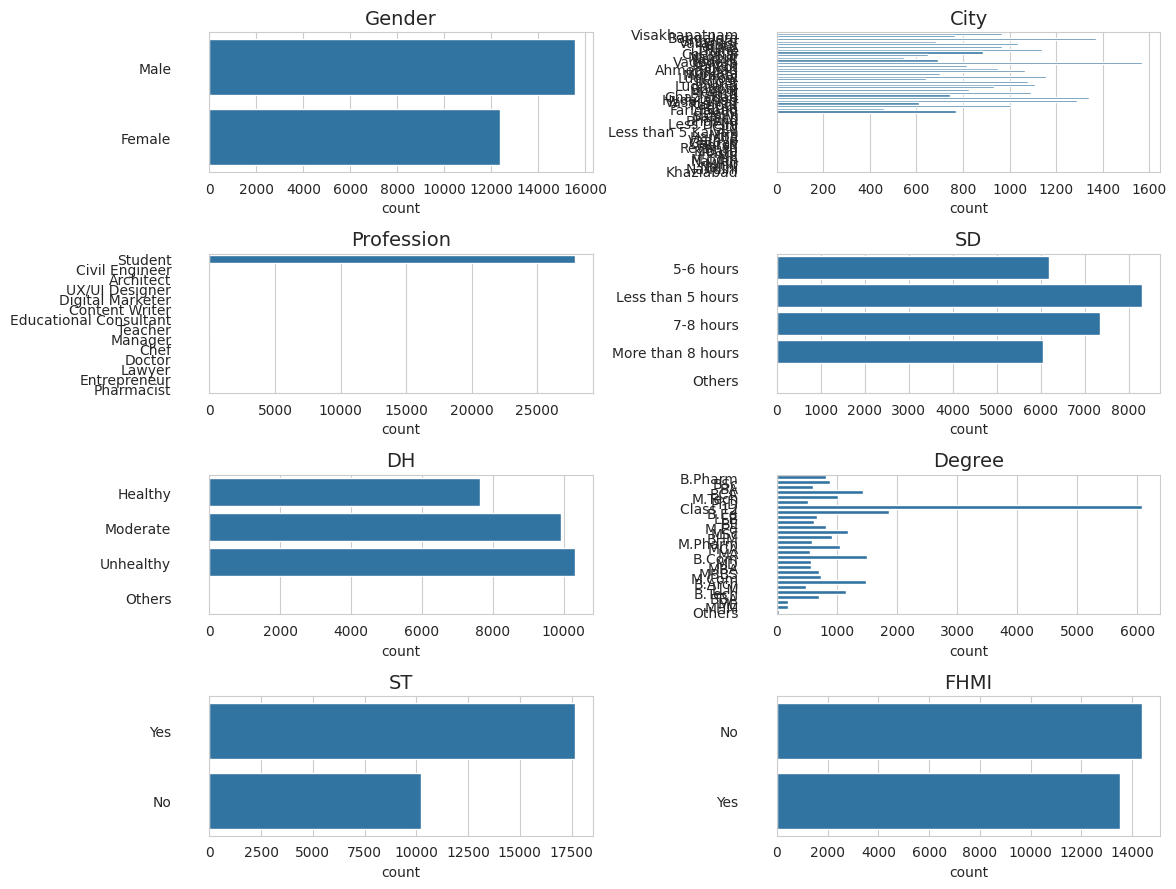

In [7]:
# Criação de uma figura com 8 subplots organizados em 4 linhas e 2 colunas para variaveis object
fig, ax = plt.subplots(4, 2, figsize=(12, 9))
ax = ax.flatten()
fig.subplots_adjust(wspace=1, hspace=1)
for i, x in enumerate(columns_object):
    sns.countplot(y=df[x], ax=ax[i])
    ax[i].set_ylabel("")
    ax[i].set_title(x, fontsize=14)
    ax[i].tick_params(axis='y', labelsize=10, pad=24)

plt.tight_layout()
plt.show()


In [8]:
display(df['City'].value_counts())
display(df['Degree'].value_counts())

City
Kalyan                1570
Srinagar              1372
Hyderabad             1340
Vasai-Virar           1290
Lucknow               1155
Thane                 1139
Ludhiana              1111
Agra                  1094
Surat                 1078
Kolkata               1066
Jaipur                1036
Patna                 1007
Visakhapatnam          969
Pune                   968
Ahmedabad              951
Bhopal                 934
Chennai                885
Meerut                 825
Rajkot                 816
Delhi                  768
Bangalore              767
Ghaziabad              745
Mumbai                 699
Vadodara               694
Varanasi               685
Nagpur                 651
Indore                 643
Kanpur                 609
Nashik                 547
Faridabad              461
Saanvi                   2
Bhavna                   2
City                     2
Harsha                   2
Less Delhi               1
M.Tech                   1
3.0                    

Degree
Class 12    6080
B.Ed        1867
B.Com       1506
B.Arch      1478
BCA         1433
MSc         1190
B.Tech      1152
MCA         1044
M.Tech      1022
BHM          925
BSc          888
M.Ed         821
B.Pharm      810
M.Com        734
BBA          696
MBBS         696
LLB          671
BE           613
BA           600
M.Pharm      582
MD           572
MBA          562
MA           544
PhD          522
LLM          482
MHM          191
ME           185
Others        35
Name: count, dtype: int64

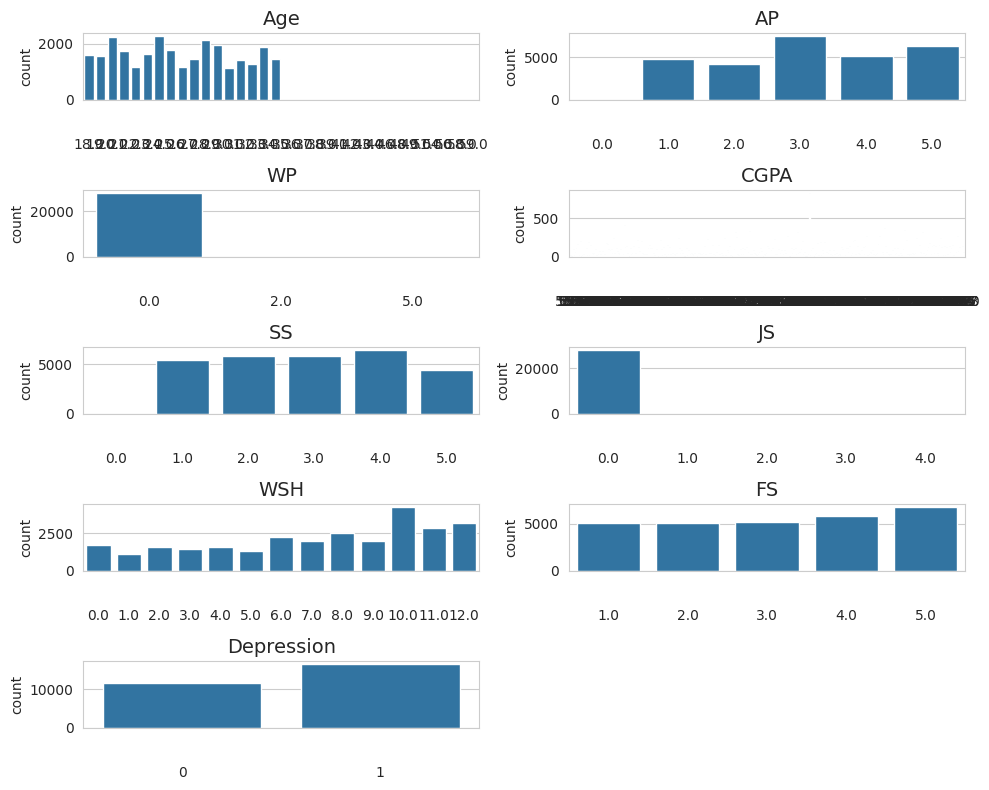

In [9]:
# Criação de uma figura com 9 subplots organizados em 5 linhas e 2 colunas para variaveis number
fig, ax = plt.subplots(5, 2, figsize=(10, 8))
ax = ax.flatten()

for i, x in enumerate(columns_numeric):
    sns.countplot(x=df[x], ax=ax[i])
    ax[i].set_xlabel("")
    ax[i].set_title(x, fontsize=14)
    ax[i].tick_params(axis='x', labelsize=10, pad=24)

ax[9].set_visible(False)
plt.tight_layout()
plt.show()


In [10]:
display(df['CGPA'].value_counts())
display(df['Age'].value_counts())

CGPA
8.0400     821
9.9600     425
5.7400     410
8.9500     371
9.2100     343
7.2500     339
7.0900     320
7.8800     318
9.4400     317
8.9100     276
9.9300     274
7.7700     269
8.7400     267
7.1000     252
9.7200     250
5.6400     247
9.3900     243
6.9900     242
6.3700     238
7.5300     234
6.7800     232
9.2400     224
8.5900     220
5.8500     216
6.1600     215
8.5800     209
5.1600     209
7.9400     208
5.8800     207
8.1700     198
5.3200     197
8.2400     194
5.5600     178
9.5600     176
8.1400     175
6.1000     169
5.1200     167
5.5700     164
8.9000     164
5.3700     159
9.7100     157
6.0000     154
6.8900     153
9.4100     153
6.8300     153
9.8900     151
9.6300     150
6.2500     147
5.8200     144
6.7500     143
7.0400     143
8.7300     142
8.9600     142
9.6000     142
9.7900     141
9.8600     141
9.9700     139
5.7600     139
9.6700     136
8.6200     135
7.4700     135
8.5400     135
9.9500     133
9.7400     129
8.7000     128
7.2200     127
9.840

Age
24.0    2258
20.0    2237
28.0    2133
29.0    1950
33.0    1893
25.0    1784
21.0    1726
23.0    1645
18.0    1587
19.0    1560
34.0    1468
27.0    1462
31.0    1427
32.0    1262
22.0    1160
26.0    1155
30.0    1145
35.0      10
38.0       8
36.0       7
42.0       4
39.0       3
48.0       3
46.0       2
43.0       2
37.0       2
44.0       1
51.0       1
49.0       1
58.0       1
54.0       1
59.0       1
56.0       1
41.0       1
Name: count, dtype: int64

## Normalização e transformação de dados.

In [11]:
# Validando valores nulos:
display(df.isnull().sum())
display(df.isna().sum())

Gender        0
Age           0
City          0
Profession    0
AP            0
WP            0
CGPA          0
SS            0
JS            0
SD            0
DH            0
Degree        0
ST            0
WSH           0
FS            3
FHMI          0
Depression    0
dtype: int64

Gender        0
Age           0
City          0
Profession    0
AP            0
WP            0
CGPA          0
SS            0
JS            0
SD            0
DH            0
Degree        0
ST            0
WSH           0
FS            3
FHMI          0
Depression    0
dtype: int64

In [12]:
# Removendo os valores nulos
df.dropna(inplace=True)

### Analisando as variáveis quantitativas

In [13]:
# Função para verificar outliers
def check_outliers(df):
    Q1 = df.quantile(q=.25)
    Q3 = df.quantile(q=.75)

    IQR = Q3 - Q1  # Calculando o valor do intervalo interquartil
    limit_lower = Q1 - 1.5 * IQR
    limit_upper = Q3 + 1.5 * IQR

    outliers_upper = df[(df > limit_upper)].sort_values().values
    outliers_lower = df[(df < limit_lower)].sort_values().values

    print(f'🔼 outliers_upper: {outliers_upper}')
    print(f'🔽 outliers_lower: {outliers_lower}')

    plt.figure(figsize=(8, 8))
    sns.boxplot(df)
    plt.show()

    return limit_lower, limit_upper

🔼 outliers_upper: [44. 46. 46. 48. 48. 48. 49. 51. 54. 56. 58. 59.]
🔽 outliers_lower: []


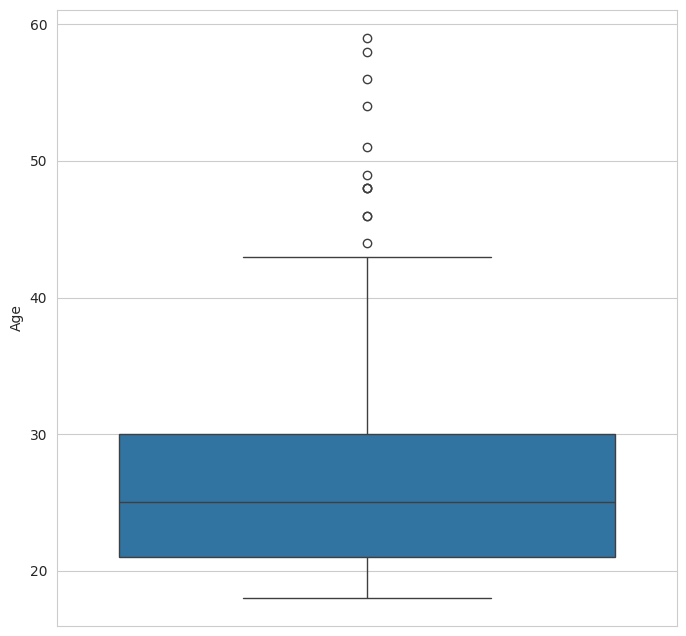

In [14]:
limit_lower, limit_upper = check_outliers(df['Age'])

🔼 outliers_upper: []
🔽 outliers_lower: []


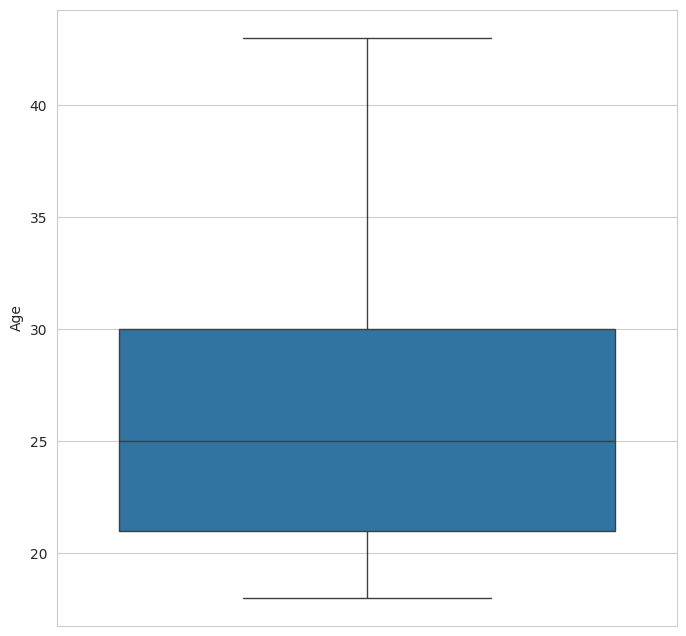

(np.float64(7.5), np.float64(43.5))

In [15]:
# Remoção dos outliers da variável Age
df.query('Age >= @limit_lower and Age <= @limit_upper', inplace=True)
check_outliers(df['Age'])

🔼 outliers_upper: []
🔽 outliers_lower: [0. 0. 0. 0. 0. 0. 0. 0. 0.]


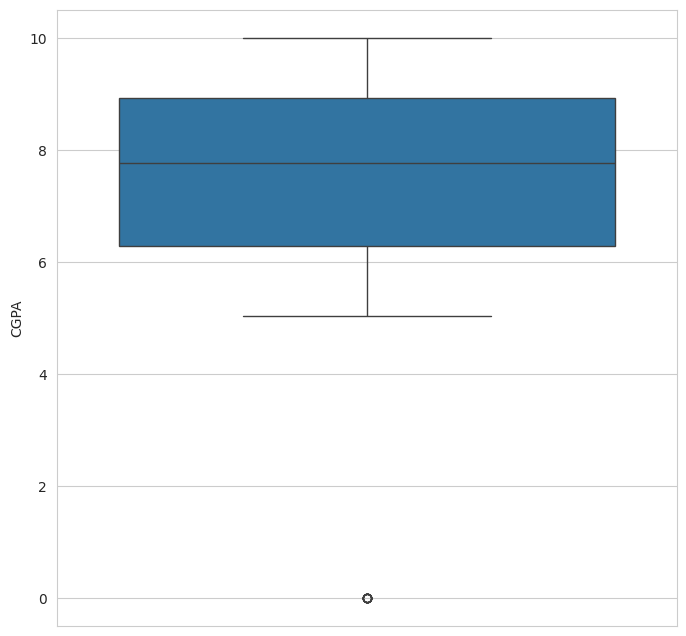

In [16]:
limit_lower, limit_upper = check_outliers(df['CGPA'])

🔼 outliers_upper: []
🔽 outliers_lower: []


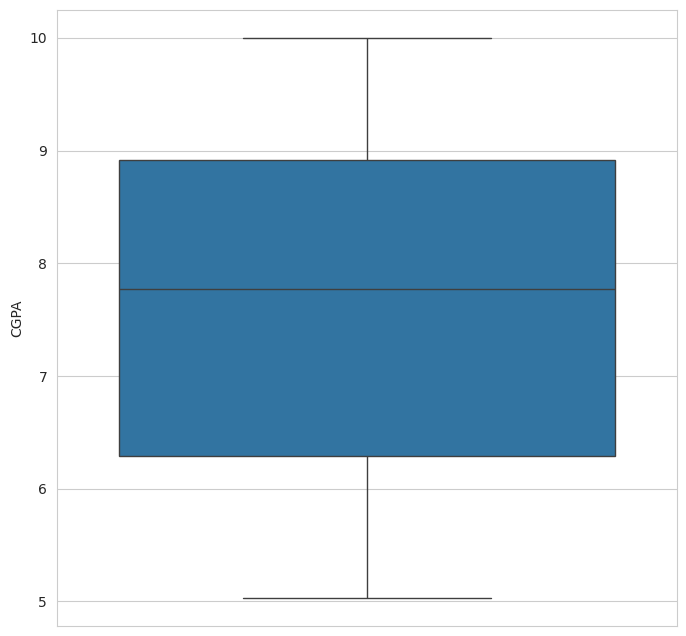

(np.float64(2.345), np.float64(12.865))

In [17]:
df.query('CGPA >= @limit_lower and CGPA <= @limit_upper',inplace=True)
check_outliers(df['CGPA'])

### Analisando as variáveis qualitativas

In [18]:
# Plotagem do grafico de torta
def pie_plot(data, labels, title):
    plt.figure(figsize=(6, 6))
    plt.pie(data, labels=labels, autopct='%1.1f%%')
    plt.title(title)
    plt.show()

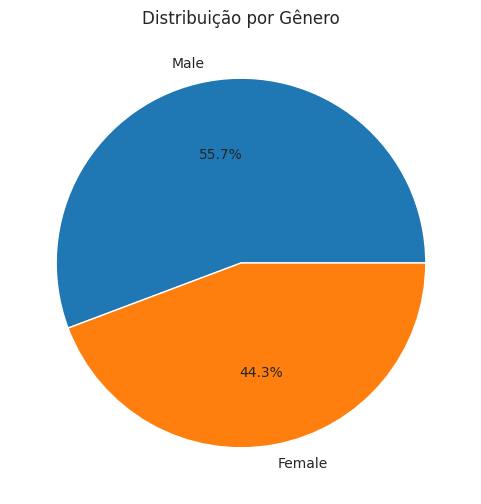

In [19]:
# Plotagem para a variável Gender
gender_counts = df['Gender'].value_counts()
pie_plot(data=gender_counts, labels=gender_counts.index,
         title='Distribuição por Gênero')

In [20]:
# Convertendo a variavel para binaria
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1}).astype('int64')

In [21]:
# Removendo as cidades com menos de 2 ocorrências
filtered_cities = df['City'].value_counts()[lambda x: x > 2].index
display(filtered_cities)
df.query('City in @filtered_cities', inplace=True)
df['City'].value_counts()

Index(['Kalyan', 'Srinagar', 'Hyderabad', 'Vasai-Virar', 'Lucknow', 'Thane',
       'Ludhiana', 'Agra', 'Surat', 'Kolkata', 'Jaipur', 'Patna',
       'Visakhapatnam', 'Pune', 'Ahmedabad', 'Bhopal', 'Chennai', 'Meerut',
       'Rajkot', 'Delhi', 'Bangalore', 'Ghaziabad', 'Mumbai', 'Vadodara',
       'Varanasi', 'Nagpur', 'Indore', 'Kanpur', 'Nashik', 'Faridabad'],
      dtype='object', name='City')

City
Kalyan           1570
Srinagar         1371
Hyderabad        1339
Vasai-Virar      1290
Lucknow          1153
Thane            1139
Ludhiana         1110
Agra             1093
Surat            1077
Kolkata          1065
Jaipur           1036
Patna            1007
Visakhapatnam     969
Pune              967
Ahmedabad         949
Bhopal            933
Chennai           883
Meerut            824
Rajkot            814
Delhi             768
Bangalore         767
Ghaziabad         744
Mumbai            699
Vadodara          692
Varanasi          684
Nagpur            650
Indore            643
Kanpur            609
Nashik            545
Faridabad         461
Name: count, dtype: int64

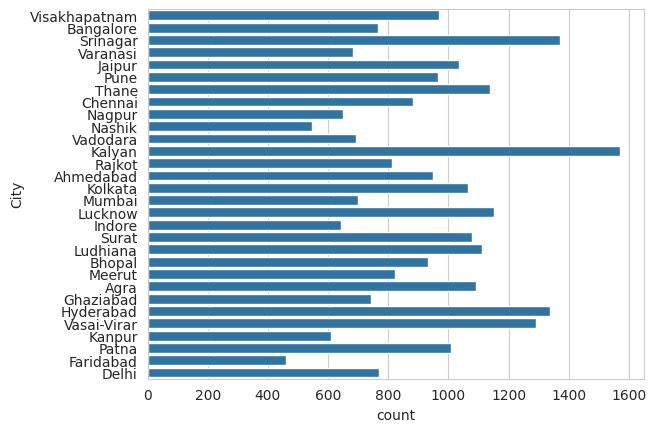

In [22]:
plt.Figure(figsize=(10, 8))
sns.countplot(df['City'])
plt.show()

In [23]:
# Removendo a coluna Profession
df.drop(columns=['Profession'], axis=1, inplace=True)

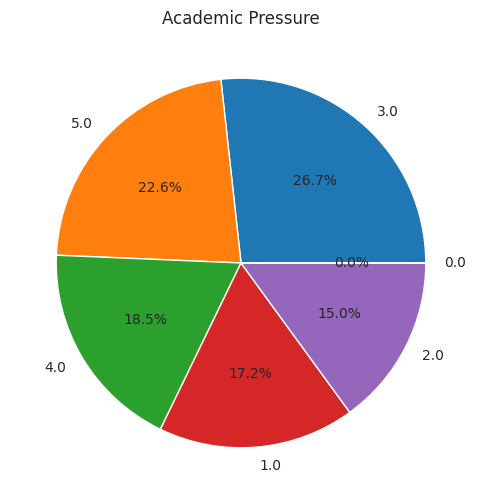

In [24]:
# Plotando o grafico de torta para 
ap_counts = df['AP'].value_counts()
pie_plot(data=ap_counts, labels=ap_counts.index, title='Academic Pressure')

In [25]:
# Removendo as Academic Pressure com menos de 1
df.query('AP > 0.0 ', inplace=True)

In [26]:
# Removendo a coluna Work Pressure
df.drop(columns=['WP'], inplace=True)

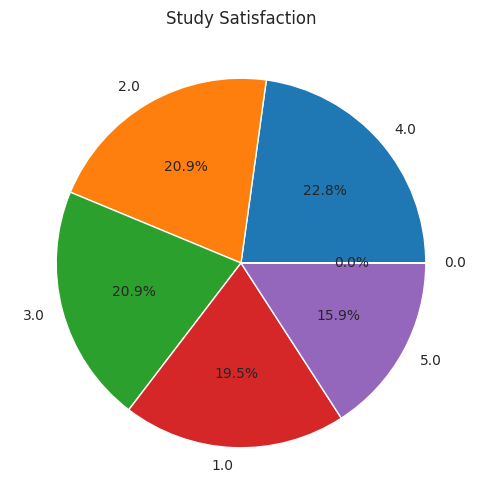

In [27]:
ss_counts = df['SS'].value_counts()
pie_plot(data=ss_counts, labels=ss_counts.index, title='Study Satisfaction')

In [28]:
df.query('SS > 0.0 ', inplace=True)

In [29]:
df.drop(columns=['JS'], inplace=True)

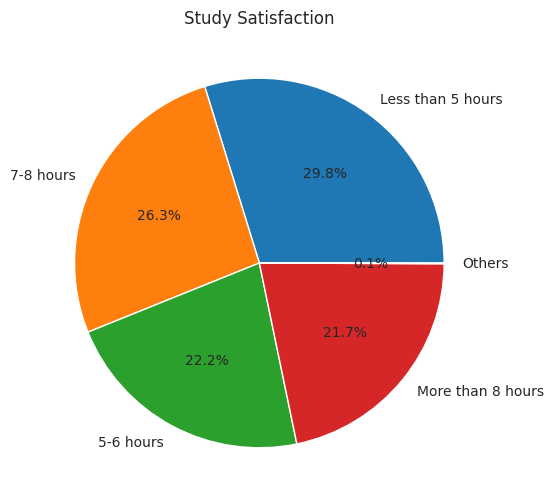

In [30]:
sd_counts = df['SD'].value_counts()
pie_plot(data=sd_counts, labels=sd_counts.index, title='Study Satisfaction')

In [31]:
df.query('SD != "Others" ', inplace=True)

In [32]:
mapping = {
    'Less than 5 hours': 1,
    '5-6 hours': 2,
    '7-8 hours': 3,
    'More than 8 hours': 4
}

df['SD'] = df['SD'].map(mapping)

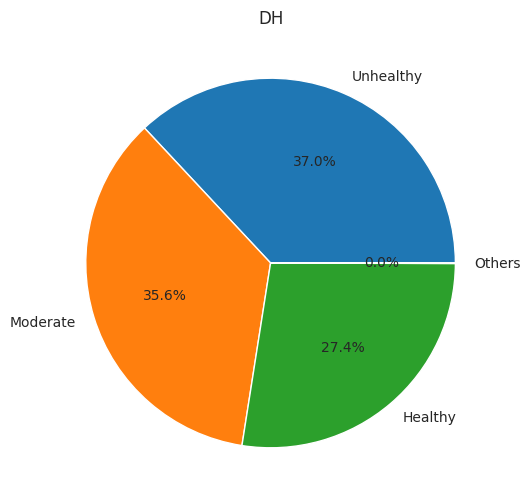

In [33]:
dh_counts = df['DH'].value_counts()
pie_plot(data=dh_counts, labels=dh_counts.index, title='DH')

In [34]:
df.query('DH != "Others" ', inplace=True)

In [35]:
def categorize_education(degree):
    if degree == "Class 12":
        return 0  # Secondary Education
    elif degree in ["PhD", "Others", "MSc", "MHM", "ME", "MD", "MCA", "MBBS", "MBA", "MA",
                    "M.Tech", "M.Pharm", "M.Ed", "M.Com", "LLM"]:
        return 1  # Postgraduate Degree
    elif degree in ["LLB", "BSc", "BHM", "BE", "BCA", "BBA", "BA", "B.Tech",
                    "B.Pharm", "B.Ed", "B.Com", "B.Arch"]:
        return 2  # Undergraduate Degree


df["Degree"] = df["Degree"].apply(categorize_education).astype('category')

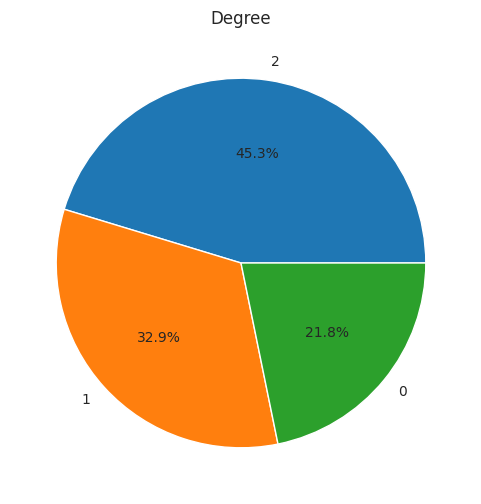

In [36]:
degree_counts = df['Degree'].value_counts()
pie_plot(data=degree_counts, labels=degree_counts.index, title='Degree')

In [37]:
mapping = {
    'No': 0,
    'Yes': 1
}

df['ST'] = df['ST'].map(mapping)

In [38]:
df['FHMI'] = df['FHMI'].map({'No': 0, 'Yes': 1}).astype('int64')

In [41]:
columns_object = df.select_dtypes(include=['object']).columns.tolist()


plt.figure(figsize=(16,9))
sns.heatmap(df[columns_object].corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Correlação")
plt.show()

ValueError: could not convert string to float: 'Visakhapatnam'

<Figure size 1600x900 with 0 Axes>

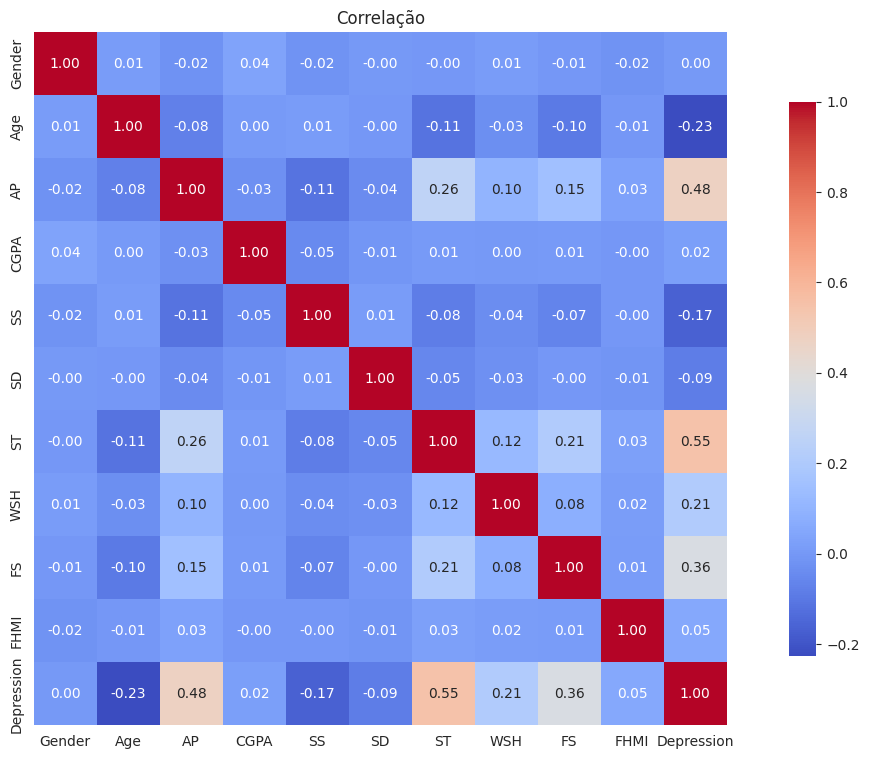

In [42]:
columns_numeric = df.select_dtypes(include=['number']).columns.tolist()

plt.figure(figsize=(16,9))
sns.heatmap(df[columns_numeric].corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Correlação")
plt.show()

## Modelagem e Treinamento

In [144]:
df_dummies = pd.get_dummies(df, columns=['City'], dtype=int, drop_first=True)

In [44]:
df.shape

(27816, 14)

## Modelo Logisitico

### Gerando formula para o modelo

In [ ]:
df_dummies.columns = df_dummies.columns.str.replace('-', '_', regex=True)

list_colums_dummies = list(df_dummies.drop(columns=['Depression']).columns)
formula_dummies_model = ' + '.join(list_colums_dummies)
formula_dummies_model = 'Depression ~ ' + formula_dummies_model
formula_dummies_model

'Depression ~ Gender + Age + City + AP + CGPA + SS + SD + DH + Degree + ST + WSH + FS + FHMI'

### Realizando o treino do modelo:

In [46]:
model = sm.Logit.from_formula(formula_dummies_model, df).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.347886
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Depression   No. Observations:                27816
Model:                          Logit   Df Residuals:                    27772
Method:                           MLE   Df Model:                           43
Date:                Tue, 11 Feb 2025   Pseudo R-squ.:                  0.4872
Time:                        17:26:02   Log-Likelihood:                -9676.8
converged:                       True   LL-Null:                       -18869.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -3.5299      0.196    -17.990      0.000      -3.914      -3.145
City[T.Ahmedabad]         0.5725      0.134      4.271      0.000       0.310       0.835
City[T.Bangalore]         0.3417      0.142      2.408      0.016       0.064       0.620
City[T.Bhopal]            0.4178      0.132      3.159      0.002       0.159       0.677
City[T.Chennai]           0.1738      0.135      1.285      0.199      -0.091       0.439
City[T.Delhi]             0.3539      0.142      2.498      0.012       0.076       0.632
City[T.Faridabad]         0.4158      0.165      2.516      0.012       0.092       0.740
City[T.Ghaziabad]         0.3018      0.144      2.096      0.036       0.020       0.584
City[T.Hyderabad]         0.5476      0.122      4.477      0.000       0.308       0.787
City[T.Indore]            0.2918      0.148      1.977      0.048       0.003       0.581
City[T.Jaipur]            0.0211      0.129      0.164      0.870      -0.231       0.273
City[T.Kalyan]            0.3464      0.119      2.922      0.003       0.114       0.579
City[T.Kanpur]            0.2877      0.150      1.917      0.055      -0.006       0.582
City[T.Kolkata]           0.4710      0.132      3.575      0.000       0.213       0.729
City[T.Lucknow]           0.1758      0.127      1.388      0.165      -0.072       0.424
City[T.Ludhiana]          0.3295      0.128      2.578      0.010       0.079       0.580
City[T.Meerut]            0.4488      0.139      3.230      0.001       0.177       0.721
City[T.Mumbai]           -0.0213      0.145     -0.147      0.883      -0.306       0.263
City[T.Nagpur]           -0.0653      0.146     -0.447      0.655      -0.352       0.221
City[T.Nashik]            0.3321      0.155      2.144      0.032       0.029       0.636
City[T.Patna]             0.4829      0.130      3.708      0.000       0.228       0.738
City[T.Pune]              0.1812      0.131      1.382      0.167      -0.076       0.438
City[T.Rajkot]            0.3320      0.137      2.418      0.016       0.063       0.601
City[T.Srinagar]          0.2182      0.120      1.820      0.069      -0.017       0.453
City[T.Surat]             0.2817      0.131      2.156      0.031       0.026       0.538
City[T.Thane]             0.3705      0.127      2.914      0.004       0.121       0.620
City[T.Vadodara]          0.2314      0.143      1.616      0.106      -0.049       0.512
City[T.Varanasi]          0.0597      0.148      0.404      0.686      -0.230       0.349
City[T.Vasai-Virar]       0.2453      0.123      1.990      0.047       0.004       0.487
City[T.Visakhapatnam]     0.3109      0.133      2.346      0.019       0.051       0.571
DH[T.Moderate]            0.4731      0.045     10.435      0.000       0.384       0.562
DH[T.Unhealthy]           1.0958      0.047     23.563      0.000       1.005       1.187
Degree[T.1]               0.1778      0.064      2.775      0.006       0.052       0.303
D

### Executando o processo de stepwise para remoção de variaveis.

In [47]:
stepwise_model = stepwise(model, pvalue_limit=0.05)

Regression type: Logit 

Estimating model...: 
 Depression ~ Q('City[T.Ahmedabad]') + Q('City[T.Bangalore]') + Q('City[T.Bhopal]') + Q('City[T.Chennai]') + Q('City[T.Delhi]') + Q('City[T.Faridabad]') + Q('City[T.Ghaziabad]') + Q('City[T.Hyderabad]') + Q('City[T.Indore]') + Q('City[T.Jaipur]') + Q('City[T.Kalyan]') + Q('City[T.Kanpur]') + Q('City[T.Kolkata]') + Q('City[T.Lucknow]') + Q('City[T.Ludhiana]') + Q('City[T.Meerut]') + Q('City[T.Mumbai]') + Q('City[T.Nagpur]') + Q('City[T.Nashik]') + Q('City[T.Patna]') + Q('City[T.Pune]') + Q('City[T.Rajkot]') + Q('City[T.Srinagar]') + Q('City[T.Surat]') + Q('City[T.Thane]') + Q('City[T.Vadodara]') + Q('City[T.Varanasi]') + Q('City[T.Vasai-Virar]') + Q('City[T.Visakhapatnam]') + Q('DH[T.Moderate]') + Q('DH[T.Unhealthy]') + Q('Degree[T.1]') + Q('Degree[T.2]') + Q('Gender') + Q('Age') + Q('AP') + Q('CGPA') + Q('SS') + Q('SD') + Q('ST') + Q('WSH') + Q('FS') + Q('FHMI')
Optimization terminated successfully.
         Current function value: 0.34788

In [48]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Depression   No. Observations:                27816
Model:                          Logit   Df Residuals:                    27798
Method:                           MLE   Df Model:                           17
Date:                Tue, 11 Feb 2025   Pseudo R-squ.:                  0.4859
Time:                        17:26:21   Log-Likelihood:                -9700.1
converged:                       True   LL-Null:                       -18869.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -3.2855      0.175    -18.825      0.000      -3.628      -2.943
Q('City[T.Ahmedabad]')     0.3273      0.102      3.201      0.001       0.127       0.528
Q('City[T.Hyderabad]')     0.3023      0.086      3.498      0.000       0.133       0.472
Q('City[T.Kolkata]')       0.2246      0.099      2.265      0.024       0.030       0.419
Q('City[T.Patna]')         0.2376      0.097      2.444      0.015       0.047       0.428
Q('DH[T.Moderate]')        0.4737      0.045     10.488      0.000       0.385       0.562
Q('DH[T.Unhealthy]')       1.0911      0.046     23.602      0.000       1.000       1.182
Q('Degree[T.1]')           0.1739      0.064      2.737      0.006       0.049       0.299
Q('Degree[T.2]')           0.1504      0.059      2.562      0.010       0.035       0.265
Q('Age')                  -0.1180      0.005    -24.408      0.000      -0.127      -0.109
Q('AP')                    0.8397      0.015     56.296      0.000       0.811       0.869
Q('CGPA')                  0.0569      0.012      4.568      0.000       0.032       0.081
Q('SS')                   -0.2420      0.014    -17.787      0.000      -0.269      -0.215
Q('SD')                   -0.1883      0.016    -11.547      0.000      -0.220      -0.156
Q('ST')                    2.5142      0.039     64.241      0.000       2.437       2.591
Q('WSH')                   0.1168      0.005     23.474      0.000       0.107       0.127
Q('FS')                    0.5520      0.013     41.347      0.000       0.526       0.578
Q('FHMI')                  0.2455      0.036      6.733      0.000       0.174       0.317
==========================================================================================
"""

### Analisando os resultados do modelo

In [49]:
def confusion_matrix_plot(predicts, observated, cutoff):

    values = predicts.values

    binary_prediction = []

    for item in values:
        if item < cutoff:
            binary_prediction.append(0)
        else:
            binary_prediction.append(1)

    cm = confusion_matrix(binary_prediction, observated)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()

    sensitivity = recall_score(observated, binary_prediction, pos_label=1)
    specificity = recall_score(observated, binary_prediction, pos_label=0)
    accuracy = accuracy_score(observated, binary_prediction)

    indicators = pd.DataFrame({'Sensitividade': [sensitivity],
                               'Especificidade': [specificity],
                               'Acurácia': [accuracy]})
    return indicators

In [ ]:
df_dummies['phat'] = stepwise_model.predict()

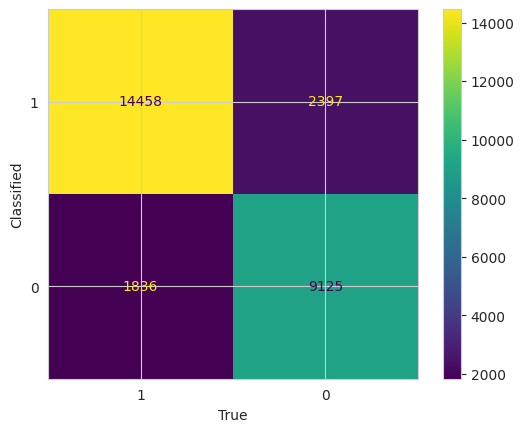

,Sensitividade,Especificidade,Acurácia
0,0.88732,0.791963,0.847821


In [ ]:
confusion_matrix_plot(observated=df_dummies['Depression'],
                      predicts=df_dummies['phat'],
                      cutoff=0.5)

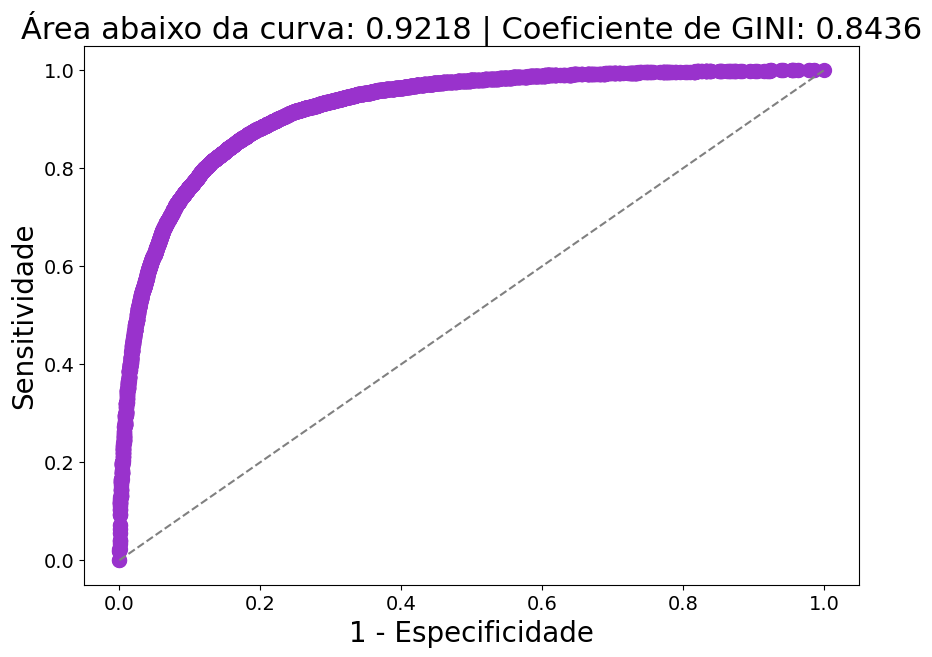

In [ ]:
fpr, tpr, thresholds = roc_curve(df_dummies['Depression'],
                                 df_dummies['phat'])
roc_auc = auc(fpr, tpr)

gini = (roc_auc - 0.5)/(0.5)

# Plotando a curva ROC
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, marker='o', color='darkorchid', markersize=10, linewidth=3)
plt.plot(fpr, fpr, color='gray', linestyle='dashed')
plt.title('Área abaixo da curva: %g' % round(roc_auc, 4) +
          ' | Coeficiente de GINI: %g' % round(gini, 4), fontsize=22)
plt.xlabel('1 - Especificidade', fontsize=20)
plt.ylabel('Sensitividade', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show()

## Árvore de Decisão

### Separando as variasveis preditoras da target

In [ ]:
X = df_dummies.drop(columns=['Depression', 'phat'])
y = df_dummies['Depression']

### Realizando a divisão do dataframe em teste e treino

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

In [156]:
display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)

(20832, 41)

(20832,)

(6944, 41)

(6944,)

In [ ]:
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=3,
                             random_state=42)

clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [ ]:
pred = clf.predict(X_test)

y_prob = clf.predict_proba(X_test)[:, -1]

ac = accuracy_score(y_test, pred)
bac = balanced_accuracy_score(y_test, pred)
print(f'accuracy_score: {ac:.1%}')
print(f'balanced_accuracy_score: {bac:.1%}')

# Calculando AUC
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC: {auc_score:.2%}")
print(f"GINI: {(2*auc_score-1):.2%}")


print('\n', classification_report(y_test, pred))

accuracy_score: 82.3%
balanced_accuracy_score: 80.9%
AUC-ROC: 87.34%
GINI: 74.67%

               precision    recall  f1-score   support

           0       0.83      0.72      0.77      2896
           1       0.82      0.90      0.85      4048

    accuracy                           0.82      6944
   macro avg       0.82      0.81      0.81      6944
weighted avg       0.82      0.82      0.82      6944



[Text(0.5, 0.875, 'x[8] <= 0.5\ngini = 0.485\nsamples = 20832\nvalue = [8607, 12225]'),
 Text(0.25, 0.625, 'x[2] <= 3.5\ngini = 0.355\nsamples = 7606\nvalue = [5849, 1757]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[10] <= 3.5\ngini = 0.224\nsamples = 5522\nvalue = [4814, 708]'),
 Text(0.0625, 0.125, 'gini = 0.144\nsamples = 3874\nvalue = [3572, 302]'),
 Text(0.1875, 0.125, 'gini = 0.371\nsamples = 1648\nvalue = [1242, 406]'),
 Text(0.375, 0.375, 'x[10] <= 2.5\ngini = 0.5\nsamples = 2084\nvalue = [1035, 1049]'),
 Text(0.3125, 0.125, 'gini = 0.44\nsamples = 880\nvalue = [593, 287]'),
 Text(0.4375, 0.125, 'gini = 0.465\nsamples = 1204\nvalue = [442, 762]'),
 Text(0.75, 0.625, 'x[2] <= 2.5\ngini = 0.33\nsamples = 13226\nvalue = [2758, 10468]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'x[10] <= 2.5\ngini = 0.5\nsamples = 3110\nvalue = [1534, 1576]'),
 Text(0.5625, 0.125, 'gini = 0.409\nsamples = 1135\nvalue = [810, 325]'),
 Text(0.6875, 0.125, 'gini = 0.464\nsamples 

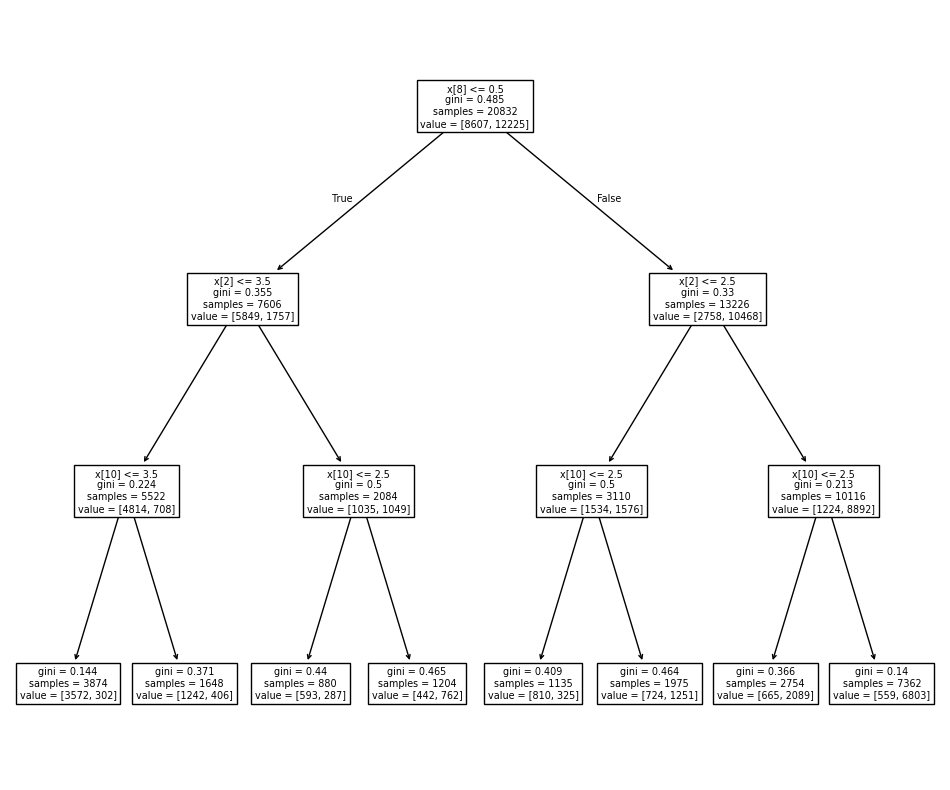

In [159]:
plt.figure(figsize=(12, 10))
plot_tree(clf)